### Examine the Data

In [28]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import pickle
import statsmodels.api as sm

In [29]:

# Read the dataset
df_raw = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'ms'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [30]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [31]:
len(df_raw)

20001

### Plot the source data

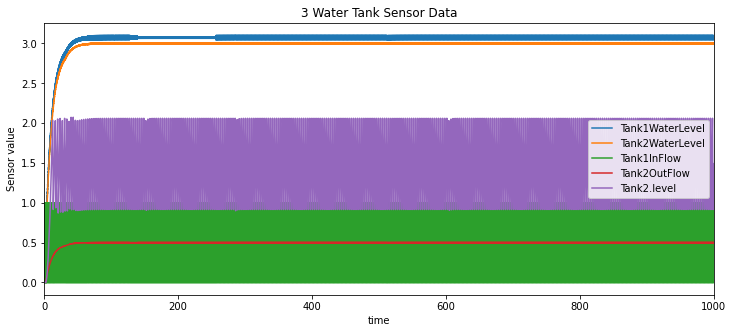

In [32]:
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''
ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df_raw['Tank2WaterLevel'].plot(legend=True)
df_raw['Tank1InFlow'].plot(legend=True)
df_raw['Tank2OutFlow'].plot(legend=True)
# df_raw['wt3_valve'].plot(legend=True)
# df_raw['Tank3OutFlow'].plot(legend=True)
df_raw['Tank2.level'].plot(legend=True)
plt.show()

In [33]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [34]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.255233e+01
p-value                 2.192107e-23
#lags                   4.600000e+01
#observations           1.995400e+04
critical value (1%)    -3.430678e+00
critical value (5%)    -2.861685e+00
critical value (10%)   -2.566847e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [35]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [36]:
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
#     return pd.DataFrame(normalised_data), means, stds
    return pd.DataFrame(normalised_data), means, stds


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data, means, stds = normalise_timeseries(df_raw)



In [37]:
# norm_vars = pd.concat([means, stds], axis=1)
# norm_vars

In [38]:
# norm_vars.to_csv(file_path)

### Save the mean and standard deviations globally or on disk

In [39]:
### METHOD ONE: USE %STORE MAGIC COMMAND
stored_norm_vars = pd.concat([means, stds], axis=1) # Stored Normalisation variables
%store stored_norm_vars

### METHOD TWO: SAVE AS A FILE
file_path = 'norm_var.csv'
norm_vars = pd.concat([means, stds], axis=1)
norm_vars.to_csv(file_path)

print(f'Normalisation variables saved successfully to {file_path}')

Stored 'stored_norm_vars' (DataFrame)
Normalisation variables saved successfully to norm_var.csv


In [40]:
df = normalised_data

In [41]:
df

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,-0.58372,-0.563189,-0.162242
999.85,0.239056,0.140814,0.998751,0.133595,-0.58372,-0.563189,-0.105704
999.90,0.175745,0.174565,-1.001251,0.169767,-0.58372,-0.563189,-0.020868


In [42]:
# Train Test Split
nobs = 3000
# train = df[:-nobs]
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(17001, 3000)

### VAR Model Order Selection

In [43]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 43 has the least AIC value. Let us select p = 43 in the modelling


In [44]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [45]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

### Fit the VAR {{min_aic_index}}  model

In [46]:
min_aic_index

43

In [47]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jun, 2023
Time:                     19:23:47
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -72.0830
Nobs:                     16958.0    HQIC:                  -72.7295
Log likelihood:           453048.    FPE:                1.88723e-32
AIC:                     -73.0476    Det(Omega_mle):     1.66787e-32
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.010786         0.000289          -37.350           0.000
L1.Tank1WaterLevel          0.249538         0.009351           26.684           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [48]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

43

In [49]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034


In [50]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values, steps=steps)
z

array([[ 0.16545008,  0.12355735,  0.99865438,  0.1264872 , -0.56409996,
         0.94805733, -1.5111998 ],
       [ 0.27071186,  0.15467027,  0.99477634,  0.14419933, -0.57250553,
        -0.53720493, -1.44305691],
       [ 0.17577324,  0.17459924, -1.00415647,  0.1697999 , -0.57392162,
        -0.55115991, -1.38688663],
       [ 0.05748263,  0.15649081, -1.00185935,  0.16828603, -0.58275719,
        -0.55368609, -1.30392184],
       [ 0.06911994,  0.12953247,  1.00102534,  0.14378986, -0.5757488 ,
        -0.56402597, -1.24652063],
       [ 0.20471493,  0.13016245,  1.00188326,  0.12737891, -0.58417198,
        -0.55469565, -1.16343494],
       [ 0.27022247,  0.15482213,  0.97448146,  0.14434382, -0.57828928,
        -0.56700603, -1.10550102],
       [ 0.13050052,  0.17358793, -1.00622722,  0.17529401, -0.58313475,
        -0.55872009, -1.02240805],
       [ 0.05736939,  0.15616577, -0.98271278,  0.16803066, -0.57916149,
        -0.56643141, -0.96376257],
       [ 0.12198826,  0.1228

In [51]:
len(z)

20

In [52]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
850.05,0.165423,0.123577,0.998751,0.126510,-0.58372,0.939866,-1.509549
850.10,0.270704,0.154650,0.998751,0.144185,-0.58372,-0.563189,-1.436865
850.15,0.175745,0.174565,-1.001251,0.169767,-0.58372,-0.563189,-1.380262
850.20,0.057638,0.156503,-1.001251,0.168293,-0.58372,-0.563189,-1.295175
850.25,0.068970,0.129598,0.998751,0.143823,-0.58372,-0.563189,-1.238449
...,...,...,...,...,...,...,...
999.80,0.165423,0.123577,0.998751,0.126510,-0.58372,-0.563189,-0.162242
999.85,0.239056,0.140814,0.998751,0.133595,-0.58372,-0.563189,-0.105704
999.90,0.175745,0.174565,-1.001251,0.169767,-0.58372,-0.563189,-0.020868


In [53]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
df_forecast = pd.DataFrame(z, columns=attr)
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.165450,0.123557,0.998654,0.126487,-0.564100,0.948057,-1.511200
1,0.270712,0.154670,0.994776,0.144199,-0.572506,-0.537205,-1.443057
2,0.175773,0.174599,-1.004156,0.169800,-0.573922,-0.551160,-1.386887
3,0.057483,0.156491,-1.001859,0.168286,-0.582757,-0.553686,-1.303922
4,0.069120,0.129532,1.001025,0.143790,-0.575749,-0.564026,-1.246521


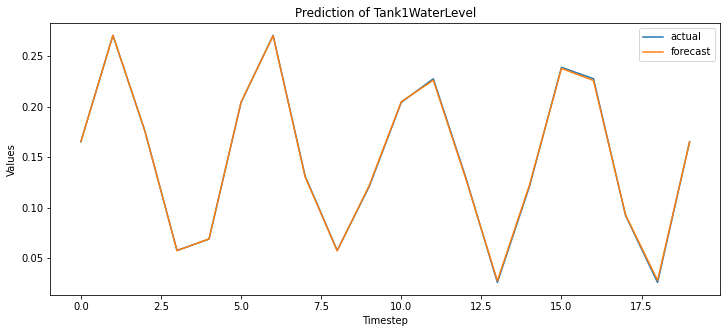

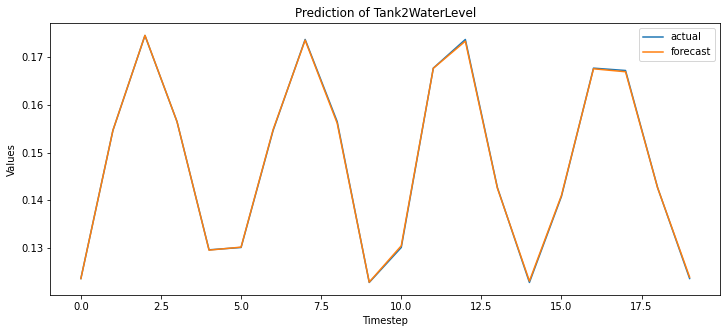

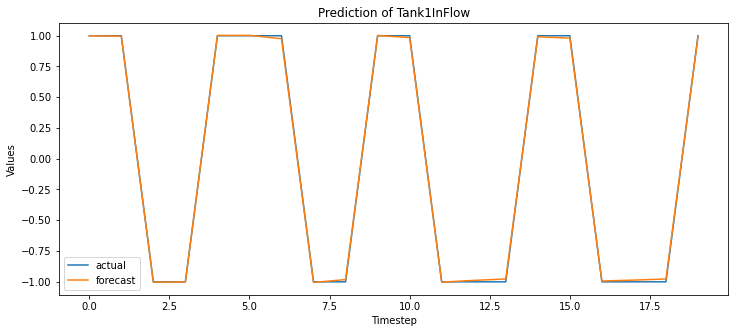

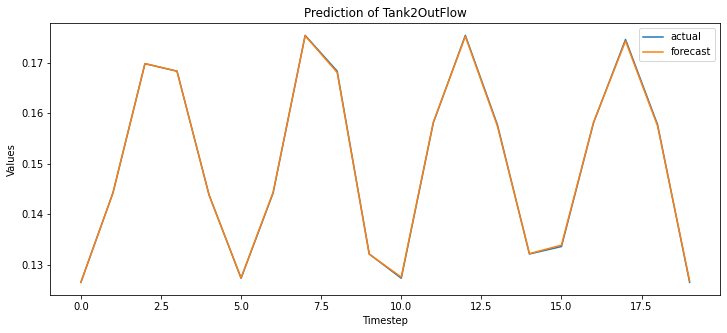

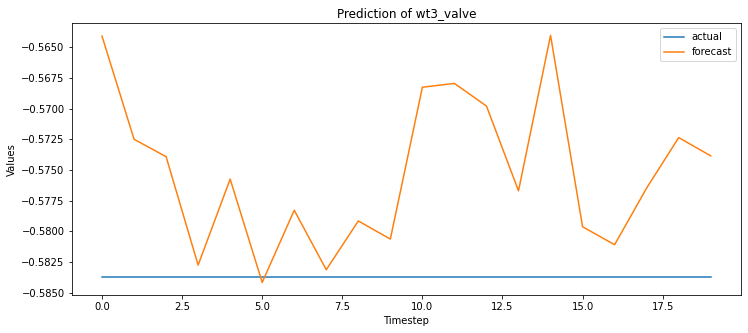

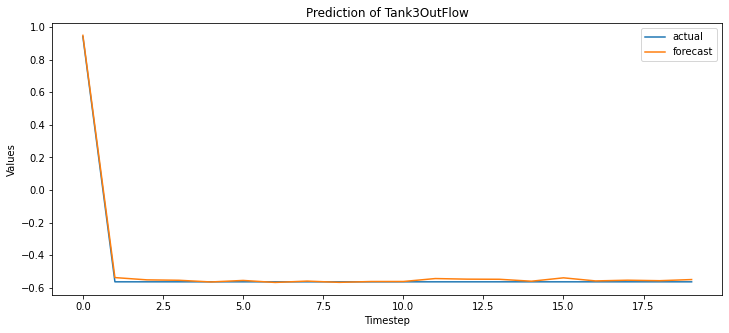

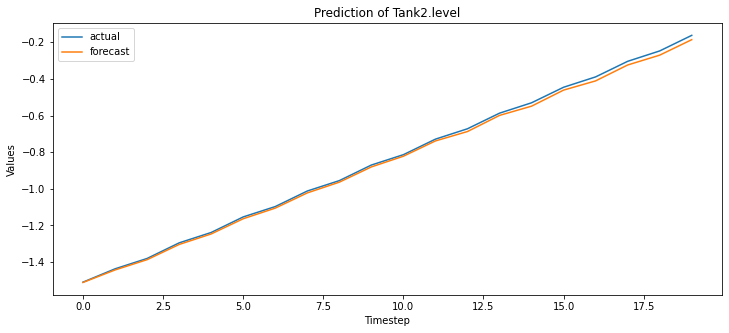

In [78]:
def plot_multiple_series(actual, pred, attr):
    if len(actual) != len(pred):
        return "Error: The lengths of the two data must be the same!"
    x = range(len(pred))
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(x, actual.iloc[:,i], label="actual")
        plt.plot(x, pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()
#     return

# plot_multiple_series(df_forecast, test.iloc[:20,:], attr)
plot_multiple_series(test.iloc[:20,:], df_forecast, attr)

In [76]:
len(df_forecast)

20

### Plot the results

In [55]:
len(train.iloc[-30:,:])

30

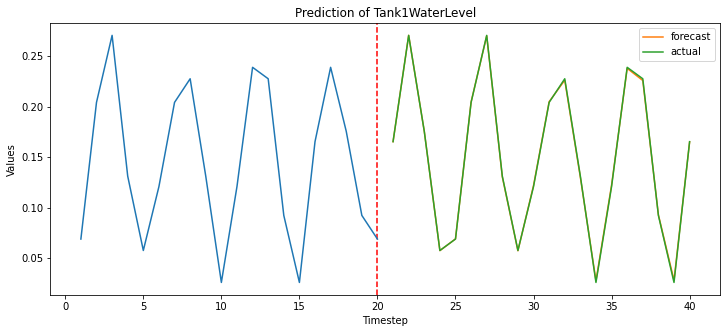

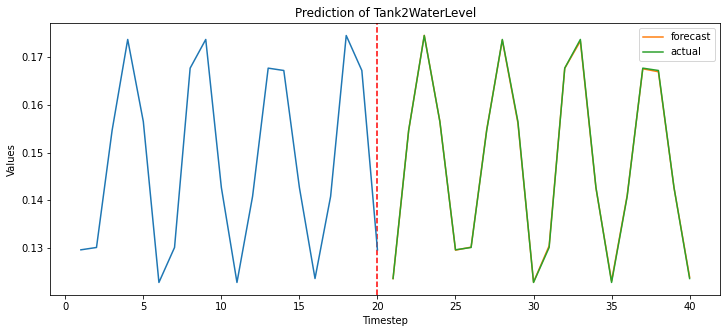

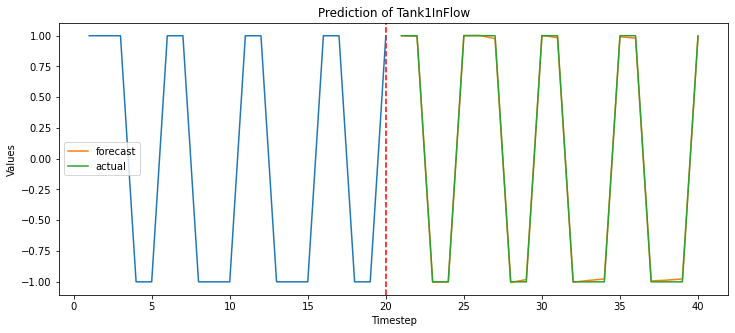

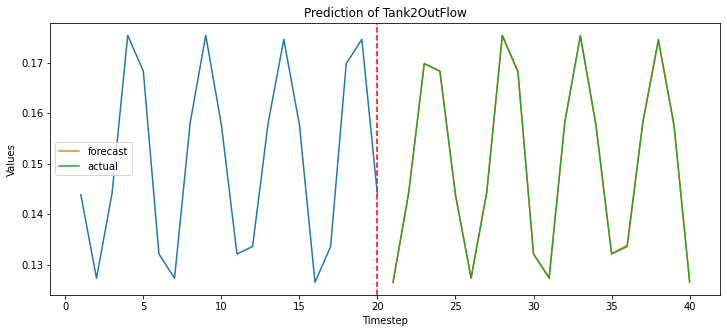

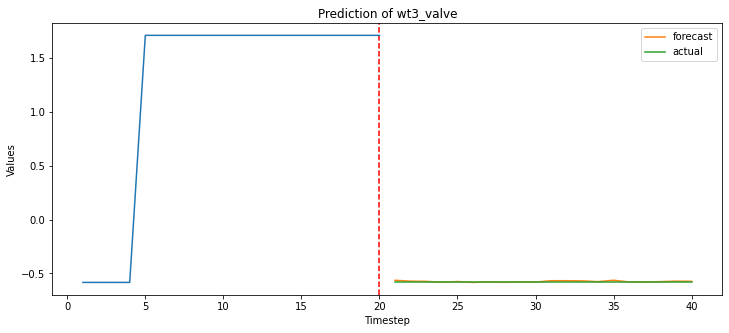

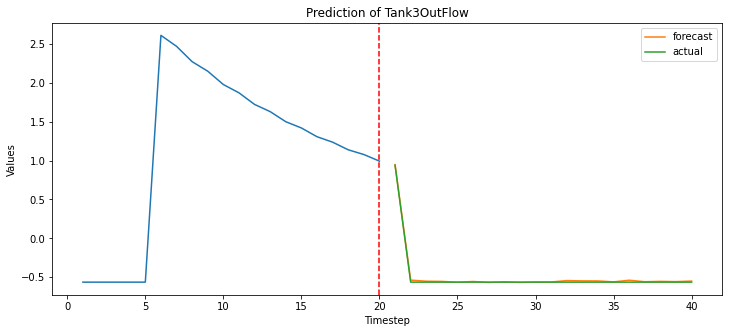

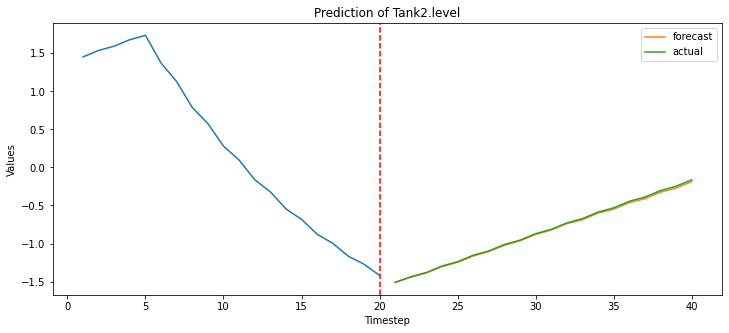

In [56]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

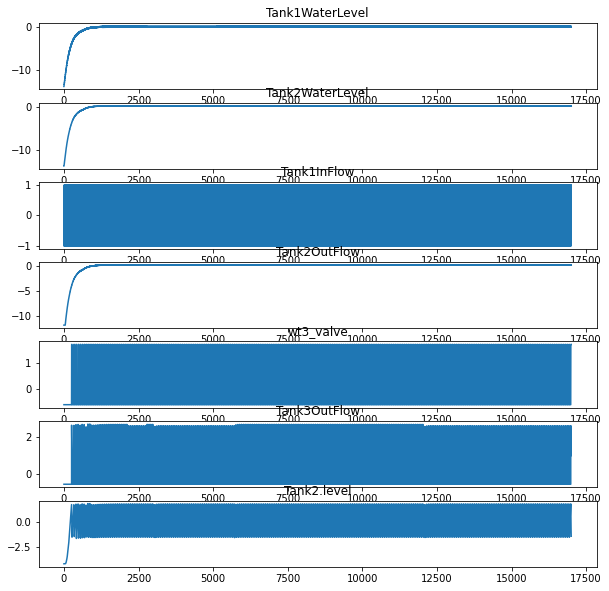

In [57]:
results.plot();

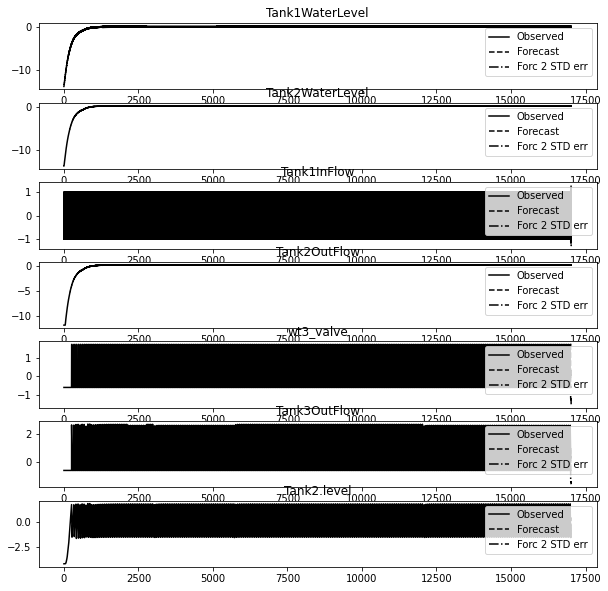

In [58]:
results.plot_forecast(20);

In [59]:
len(df_forecast)

20

### Model Evaluation (Quantitative)

In [60]:
# ### RUBBISH
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# RMSE = []
# for feat in attr:
#     RMSE.append(rmse(df[feat].iloc[:steps], df_forecast[feat]))

# print(RMSE)

In [61]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

[0.0009720029860991881, 0.0001939481049371426, 0.012765212796746724, 0.00017172647881716309, 0.010372228156742366, 0.012239564133995698, 0.013735609692407705]


In [62]:
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)

RMSEme = []
for feat in attr:
    RMSEme.append(root_mse(pred[feat], actual_test[feat]))

# tested = root_mse(df['Tank1WaterLevel'].iloc[:steps], df_forecast['Tank1WaterLevel'])
# tested
print(RMSEme)

[0.0009720029860991881, 0.0001939481049371426, 0.012765212796746724, 0.00017172647881716309, 0.010372228156742366, 0.012239564133995698, 0.013735609692407705]


### Save the model

In [63]:
# # Serialize andsave the model
# import pickle
# import statsmodels.api as sm
# with open('var_golden_model.pkl', 'wb') as f:
#     pickle.dump(results.params, f)
# print("Model saved!")

with open('var_golden_model.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")


Model saved!


### Define the faulty data
##### We need to define a different normalisation function that will use the previous values of means and stds.

In [64]:
# # Retrieve the saved and stored means and stds
# %store -r stored_norm_var
# old_means = stored_norm_var[0]
# old_stds = stored_norm_var[1]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)



In [65]:
# old_means, old_stds

In [66]:
import pandas as pd
var_df = pd.read_csv("norm_var.csv", index_col=0)
var_df

,0,1
Tank1WaterLevel,3.042181,0.221231
Tank2WaterLevel,2.967675,0.217447
Tank1InFlow,0.500625,0.500000
Tank2OutFlow,0.493641,0.042126
wt3_valve,0.254137,0.435375
Tank3OutFlow,0.480682,0.853501
Tank2.level,1.448408,0.353095


In [67]:
old_means, old_stds = var_df["0"], var_df["1"]

In [68]:
# faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_df = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)
faulty_df.index.freq = 'MS'
num_obs = 3000

# normalised_data, means, stds = normalise_timeseries(faulty_data)
normalised_data = normalise_series(faulty_df, old_means, old_stds)
faulty_data = normalised_data

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

(12001, 3000)

In [69]:
faulty_data

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
0.10,-13.736104,-13.647793,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.15,-13.504895,-13.607095,0.998751,-11.718138,-0.58372,-0.563189,-4.102034
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-0.58372,-0.563189,-4.102034
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.58372,-0.563189,-0.728886
749.85,0.131271,0.173739,-1.001251,0.175378,-0.58372,-0.563189,-0.672222
749.90,0.025990,0.142666,-1.001251,0.157702,-0.58372,-0.563189,-0.587091


### Load the model and reconstruct VAR

In [70]:
with open('var_golden_model.pkl', 'rb') as f:
    params = pickle.load(f)
    
golden_model = sm.tsa.VAR(train)
golden_model.params = params
golden_model_fit = golden_model.fit(min_aic_index)
# golden_model_fit = golden_model.fit()
golden_model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 21, Jun, 2023
Time:                     19:24:07
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -72.0830
Nobs:                     16958.0    HQIC:                  -72.7295
Log likelihood:           453048.    FPE:                1.88723e-32
AIC:                     -73.0476    Det(Omega_mle):     1.66787e-32
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.010786         0.000289          -37.350           0.000
L1.Tank1WaterLevel          0.249538         0.009351           26.684           0.000
L1.Tank2WaterLevel        

### Forecast using faulty data

In [71]:
# Use the loaded model to make predictions or perform other analyses
forecast = golden_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

array([[ 1.77336213e-01,  1.10161197e-01, -1.79679304e-01,
         1.19207632e-01,  4.65256512e+01,  2.91026234e+00,
         2.11167352e+02],
       [ 1.46386884e-02,  8.74234009e-02,  8.87242930e-01,
         1.24980068e-01,  7.61519867e+01,  6.49184993e+01,
         2.03652739e+02],
       [-5.79215840e-02,  7.07350147e-02, -2.49188572e+00,
         1.06741069e-01,  9.50722136e+01,  1.02412422e+02,
         1.91361376e+02],
       [ 7.02878956e-02,  3.50234375e-02, -9.62133761e-01,
         5.83063796e-02,  1.07428240e+02,  1.23128651e+02,
         1.76293335e+02],
       [-2.77233739e-02, -3.10630581e-02,  1.89812282e+00,
         6.21365750e-03,  1.15463086e+02,  1.33738303e+02,
         1.59921216e+02],
       [-1.20076470e-01, -2.27779490e-02,  1.79789656e-01,
         2.13333403e-02,  1.19417736e+02,  1.37686306e+02,
         1.42943396e+02],
       [-3.76812730e-02, -2.68248995e-02, -6.92781182e-01,
         4.73958745e-03,  1.21169554e+02,  1.35939745e+02,
         1.2618409

In [72]:
test_faulty

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
600.05,0.227723,0.167718,-1.001251,0.158063,1.713149,118.143843,200.645104
600.10,0.092377,0.167225,-1.001251,0.174568,1.713149,108.617680,184.214278
600.15,0.025989,0.142665,-1.001251,0.157701,1.713149,102.697693,174.003422
600.20,0.165422,0.123576,0.998751,0.126509,1.713149,94.417231,159.721195
600.25,0.239055,0.140813,0.998751,0.133594,1.713149,89.271261,150.845371
...,...,...,...,...,...,...,...
749.80,0.227724,0.167719,-1.001251,0.158064,-0.583720,-0.563189,-0.728886
749.85,0.131271,0.173739,-1.001251,0.175378,-0.583720,-0.563189,-0.672222
749.90,0.025990,0.142666,-1.001251,0.157702,-0.583720,-0.563189,-0.587091


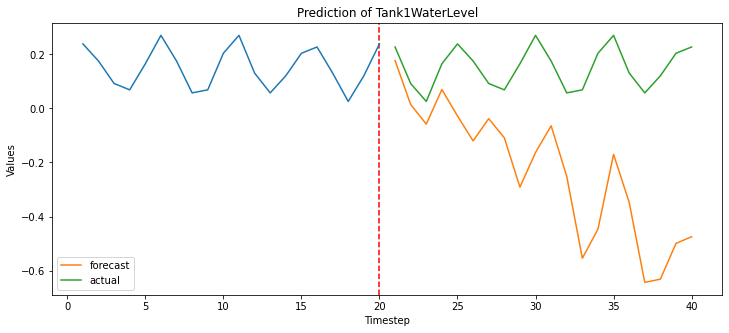

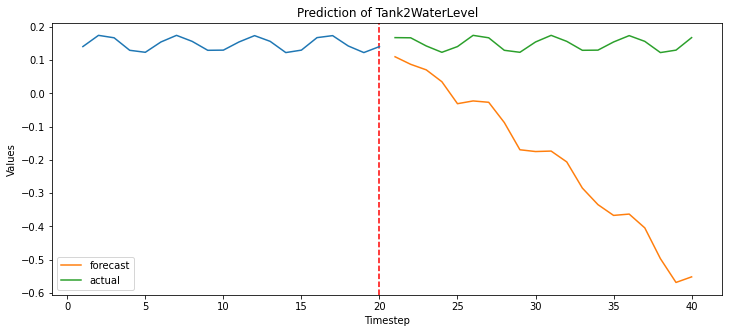

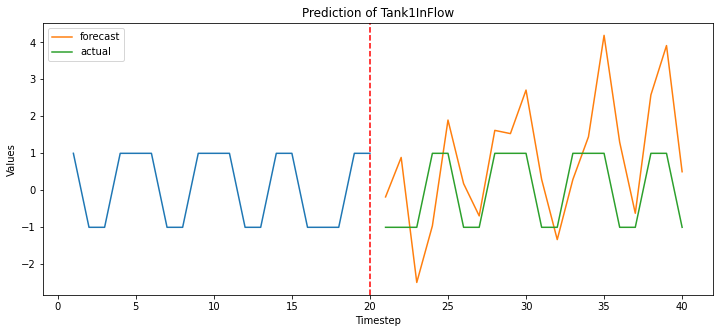

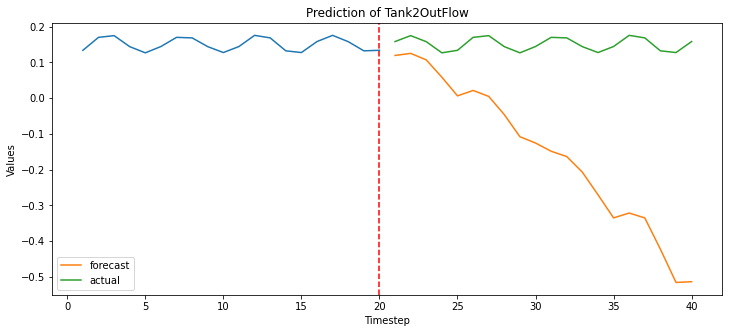

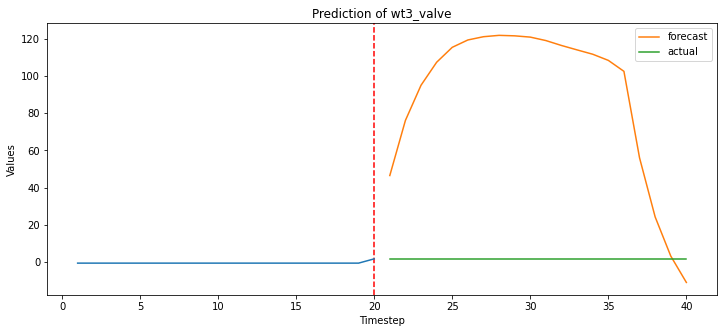

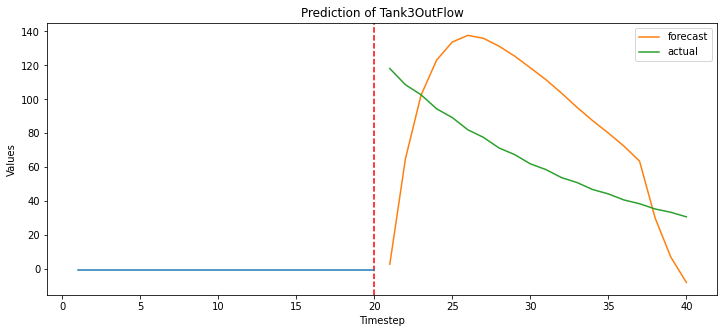

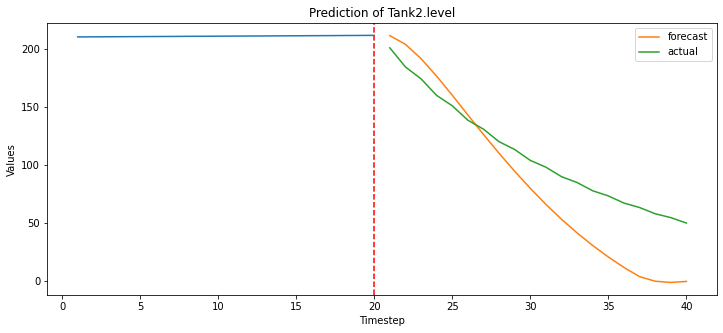

In [73]:
# attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# # fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
# fault_forecast = pd.DataFrame(forecast, columns=attr)
# input_length = 20
# # attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index_f = pd.Index(list(range(lag_order)))
#     actual_f = train_faulty.iloc[-lag_order:,:]
    
#     index_f = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual_f = actual_f.set_index(actual_index_f)
#     pred_f = fault_forecast.set_index(index_f)
#     actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual_f.iloc[:,i])
#     plt.plot(pred_f.iloc[:,i], label="forecast")
#     plt.plot(actual_test_f.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()


attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast, columns=attr)
input_length = 20
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(1,input_length+1)))
    actual_f = train_faulty.iloc[-input_length:,:]
    
    index_f = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:input_length,:].set_index(index_f)
    # draw a vertical line at x=20
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [74]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(pred_f[feat], actual_test_f[feat]))

print(RMSEf)



[0.45088140292001805, 0.4048578759040934, 1.5416402102261593, 0.36303251893211747, 97.06026917777618, 49.32886653132924, 36.761834415239164]


Evaluation of the model's performance can be done using the following:
- Accuracy
- Precision
- Recall
- F1 score

In [75]:
print("I want to stop the execution of the notebook here")
print(error)

I want to stop the execution of the notebook here


NameError: name 'error' is not defined

### Increasing the duration of faults

In [ ]:
df_test_extend = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
df_test_extend.index.freq = 'MS'
faulty_data_extend = normalise_timeseries(df_test_extend)

# faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# normalised_data_extend, means, stds = normalise_timeseries(faulty_data_extend)
# faulty_data_extend = normalised_data_extend
faulty_data_extend = df_test_extend

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = golden_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
attr = list(pd.read_csv('waterTank_Golden.csv').columns.values)[1:]
# fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
fault_forecast = pd.DataFrame(forecast_extend, columns=attr)

# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Fault Detection

In [ ]:
import scipy.stats as stats
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [ ]:
# ndf = pd.read_csv('waterTank_Golden.csv', index_col=0, header=0, parse_dates=True)
ndf = pd.read_csv('waterTank_ctrl_stuckAt0.csv', index_col=0)
ndf.plot(figsize=(16,6))

In [ ]:
# # Train best multivariate model
# var = VAR(fault_forecast)
# var_result = var.fit(min_aic_index)

# var_result.aic

In [ ]:
# Compute Train T2 metric (Hotelling's T-squared)
residuals_mean = results.resid.values.mean(axis=0)
residuals_std = results.resid.values.std(axis=0)

residuals = (results.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))
T.shape

In [ ]:
# Compute UCL - Upper Control Limit

m = results.nobs
p = results.resid.shape[-1]
alpha = 0.01

# UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL = stats.f.ppf(alpha, dfn=p, dfd=m-p) * (p*(m+1)*(m-1)/(m*m-m*p))
UCL

In [ ]:
# Set the UCL
UCL = 500

In [ ]:
# Plot Train T2 metric

plt.figure(figsize=(16,6))
# plt.plot(train.index[min_aic_index:], T)
plt.plot(train.index[min_aic_index:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [3]:
print(esc)

NameError: name 'esc' is not defined